In [400]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import naludaq
print(f"Naludaq version: {naludaq.__version__}")

Naludaq version: 0.31.7


In [401]:
from naludaq.backend import DiskAcquisition

ACQ_PATH = "data/SineWave_100MHz/"
channels = 4
# DiskAcquisition is recommended to be used as a context manager for safety
with DiskAcquisition(ACQ_PATH) as acq:
    print("Board model:", acq.params["model"])
    print("Number of events:", len(acq))
    print("Pedestals stored:", acq.pedestals is not None)

acq= DiskAcquisition(ACQ_PATH)

from naludaq.tools.pedestals.pedestals_correcter import PedestalsCorrecter
pedestals=acq.pedestals
params = acq.params
corrector = PedestalsCorrecter(params, pedestals)

Board model: dsa-c10-8
Number of events: 1013
Pedestals stored: True


This is all assuming the starting cell is correct, which is everything but sure

In [402]:
num_cells = 128
cell_data = {i: [] for i in range(num_cells)}  # Initialize storage for each cell
window_length = 64
for ev_num in range(len(acq)):
    event=acq[ev_num]
    corrected_event = corrector.run(event, correct_in_place=True)
    time=corrected_event["time"]
    time=(time[4] - time[4][0]) * 0.1 
    start_window = event['start_window'] 
    adc_values=corrected_event["data"]   
    
    for i in range(1024):
        if (start_window % 2  == 0):
            cell = i % num_cells
        else:
            cell = (i + window_length) % num_cells
        cell_data[cell].append(adc_values[4][i])  
        

cell_offset = []
for i in range(128):
    cell_offset.append(np.median(cell_data[i]))

for cell in range(num_cells):
    cell_data[cell] = np.array(cell_data[cell]) - cell_offset[cell] 

[ 0.  12.8 25.6 38.4 51.2 64.  76.8 89.6]


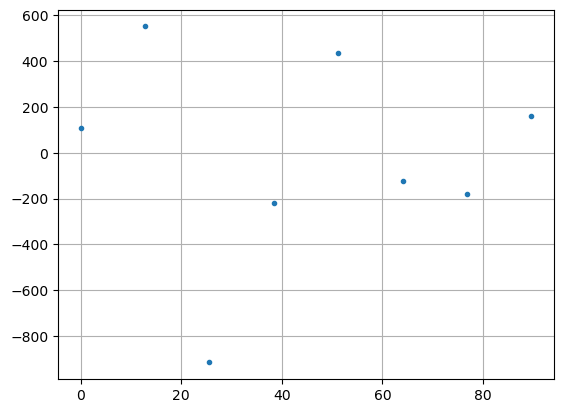

In [403]:
time_0 = np.arange(0, 8 * 12.8, 12.8)
print(time_0)
# cell 1, event 0
plt.plot(time_0, cell_data[0][0:8],'.')      # cell_data[cell][0-7 is first event and so on]
# plt.plot(time_0, cell_data[0][8:16],'.')      # cell_data[cell][8-16 is second event and so on]
plt.grid()

2606
Offset: 0.0


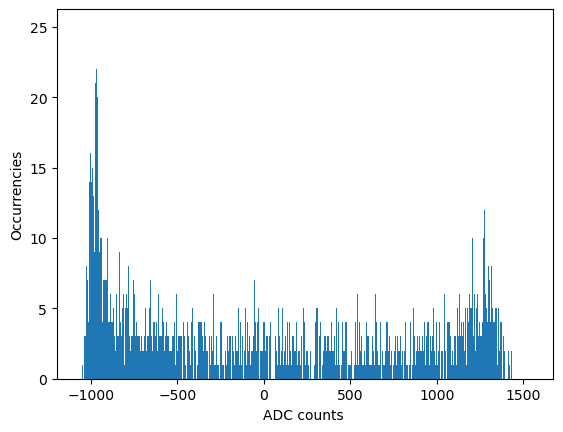

In [404]:
cell_number = 77
amp = np.max(cell_data[cell_number]) - np.min(cell_data[cell_number])
print(int(amp))
# Convert cell_data[1] to a NumPy array (if not already)
cell_1_data = np.array(cell_data[cell_number])  # Shape: (8104,)
# cell_1_data = cell_1_data - np.median(cell_1_data)  # Subtract the median
plt.hist(cell_1_data,bins=int(amp));
plt.xlabel("ADC counts ")
plt.ylabel("Occurrencies")
print('Offset:', np.median(cell_data[cell_number]))

* Look for an event that has got a point on the offset

In [405]:
# Convert cell_data[1] to a NumPy array (if not already)
cell_1_data = np.array(cell_data[cell_number])  # Shape: (8104,)
cell_1_data = cell_1_data - np.median(cell_1_data)  # Subtract the median
# Find the indices where ADC count is 348
indices_offset = np.where((cell_1_data >= 0) & (cell_1_data < 1))[0]

# Each event consists of 8 points, so compute the event index for each
event_indices = indices_offset // 8  # Integer division to find the event number

# Print results
print(f"Total occurrences of ADC 348: {len(indices_offset)}")
print(f"Indices in cell_data[{cell_number}]: {indices_offset}")
print(f"Corresponding event indices: {event_indices}")
    

Total occurrences of ADC 348: 6
Indices in cell_data[77]: [ 936 1557 2677 4509 5147 7626]
Corresponding event indices: [117 194 334 563 643 953]


### This is an example of an event like the ones we would like

In [406]:
def re_phase(event, offset):
    time_1 = np.array([0., 12.8, 25.6, 38.4, 51.2, 64., 76.8, 89.6])
    start_idx = np.where(time_1 == offset)[0][0]
    shifted_event = np.roll(event, -start_idx)
    return shifted_event

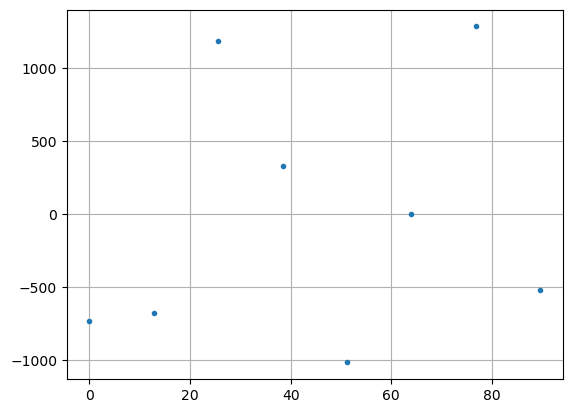

In [407]:
time_0 = np.arange(0, 8 * 12.8, 12.8)
# print(cell_data[cell_number][1281])
plt.plot(time_0, cell_data[cell_number][event_indices[2]*8:event_indices[2]*8+8],'.')      # cell_data[event][0-7 is first cell and so on]
# plt.plot(time_0, cell_data[0][8:16],'.')      # cell_data[event][0-7 is first cell and so on]
plt.grid()

* Let's shift the datapoints in ordeer to have the 0 point as the starting point and being able to obtain the phase

In [408]:
# Original time array
time_1 = np.array([0., 12.8, 25.6, 38.4, 51.2, 64., 76.8, 89.6])

# Your event data (example placeholder here — use your actual data)
event_2 = cell_data[cell_number][event_indices[2]*8:event_indices[2]*8+8]

# Step 1: find the index of 38.4
start_idx = np.where(time_1 == 64.0)[0][0]  # should be 3

# Step 2: roll the data so the point at 38.4 comes first
shifted_event_2 = np.roll(event_2, -start_idx)

Fitted parameters: A=1118.275, f=0.096, phi=0.215, C=-91.341


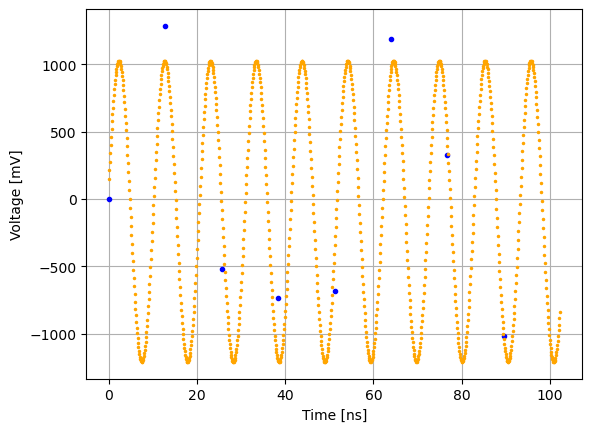

In [409]:
def sinewave(x, A, f, phi, c):
    return A * np.sin(2 * np.pi * f * x + phi) + c

p, _ = curve_fit(sinewave, time_0, shifted_event_2, p0=[2500, 0.100, 0, 0])

A_fit, f_fit, phi_fit, C_fit = p
print(f"Fitted parameters: A={A_fit:.3f}, f={f_fit:.3f}, phi={phi_fit:.3f}, C={C_fit:.3f}")

plt.plot(time_0, shifted_event_2,'.', color='blue', label="Data")
plt.plot(time, sinewave(time, *p),'.',markersize=3,color = 'orange', label="Fit")
plt.xlabel("Time [ns]")
plt.ylabel("Voltage [mV]");
plt.grid()

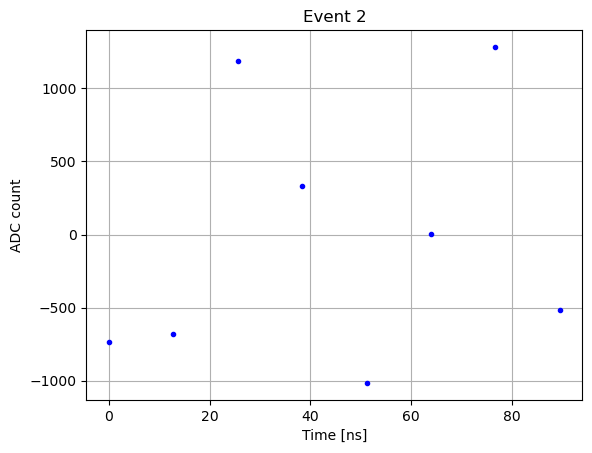

In [410]:
plt.plot(time_0, event_2,'.', color='blue', label="Data")

plt.xlabel("Time [ns]")
plt.ylabel("ADC count");
plt.title("Event 2")
plt.grid()

* Different sample [0], still with a point in 0

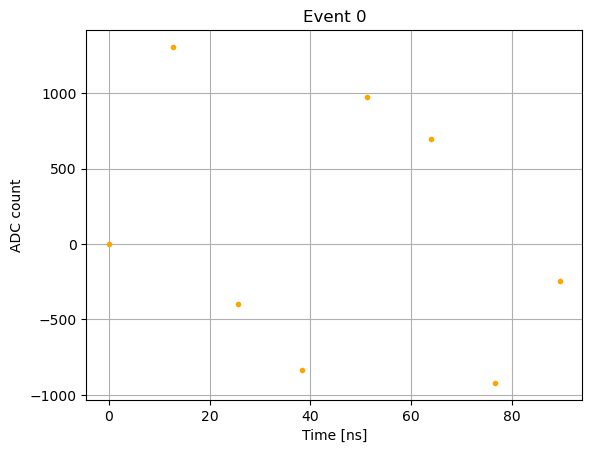

In [411]:
event_0 = cell_data[cell_number][event_indices[0]*8:event_indices[0]*8+8]
shifted_event_0 = np.roll(event_0, 0)

plt.plot(time_0, shifted_event_0,'.', color='orange', label="Data")
plt.xlabel("Time [ns]")
plt.ylabel("ADC count");
plt.title("Event 0")
plt.grid()

* Different sample [1]

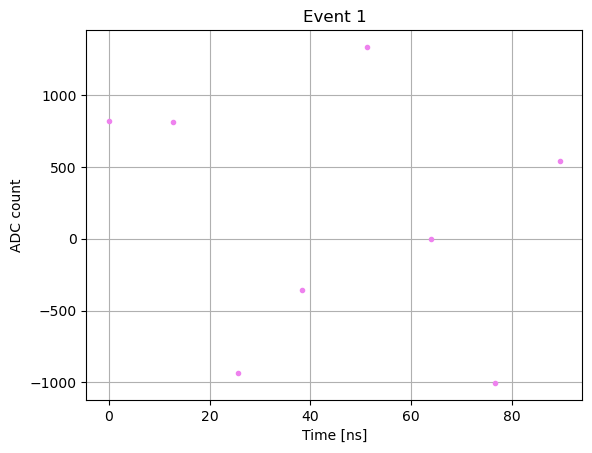

In [412]:
event_1 = cell_data[cell_number][event_indices[1]*8:event_indices[1]*8+8]
shifted_event_1 = np.roll(event_1, -5)

plt.plot(time_0, event_1,'.', color='violet', label="Data")
plt.xlabel("Time [ns]")
plt.ylabel("ADC count");
plt.title("Event 1")
plt.grid()

* Different sample [3]

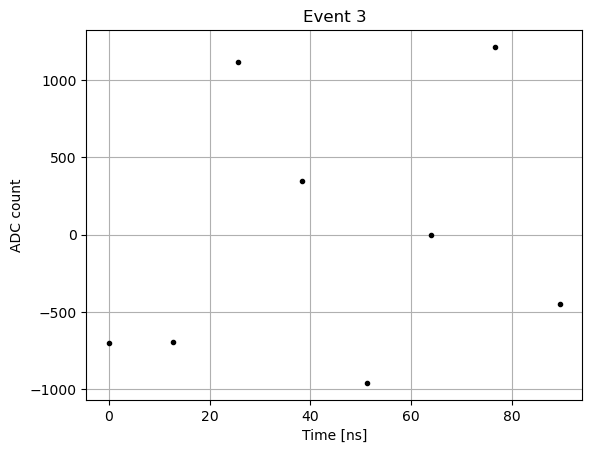

In [413]:
event_3 = cell_data[cell_number][event_indices[3]*8:event_indices[3]*8+8]

plt.plot(time_0, event_3,'.', color='black', label="Data")
plt.xlabel("Time [ns]")
plt.ylabel("ADC count");
plt.title("Event 3")
plt.grid()

* Ideal input

-68.45471059286898


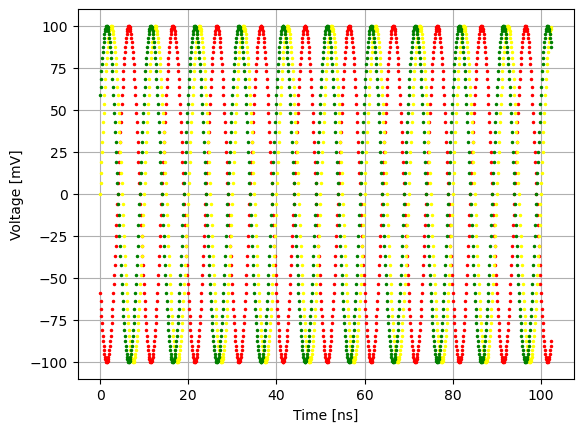

In [414]:
def sinewave(x, A, f, phi, c):
    return A * np.sin(2 * np.pi * f * x + phi) + c
t0 = 64.0
# x = np.linspace(0,51.1,512)
x = np.linspace(0,102.3,1024)
# phi = 0
# phi = np.pi
phi = -2 * np.pi * 0.100 * t0
phi_2 = -2 * np.pi * 0.100 * t0
sine = sinewave(x, 100,  0.100, phi, 0)  # Generate sine wave
sine_1 = sinewave(x, 100,  0.100, 0, 0)  
sine_2 = sinewave(x, -100,  0.100, phi_2, 0)  

plt.plot(x, sine,'.', markersize=3, color='red', label="Input Sine Wave")
plt.plot(x, sine_1,'.', markersize=3, color='yellow', label="Input Sine Wave")
plt.plot(x, sine_2,'.', markersize=3, color='green', label="Input Sine Wave")
plt.xlabel("Time [ns]")
plt.ylabel("Voltage [mV]");
plt.grid()
print(sine[128])

* Input values

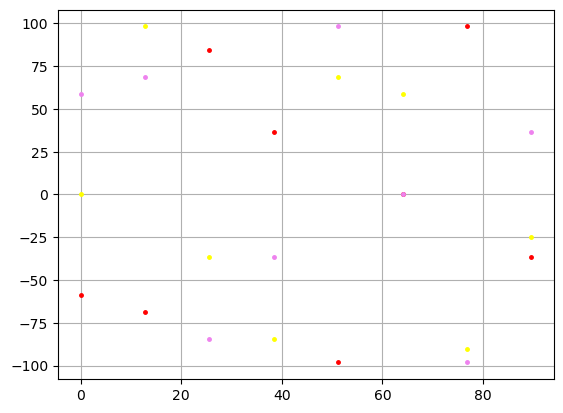

In [415]:
Input = []
Input_1 = []
Input_2 = []
for i in range(8):
    Input.append(sine[i*128])
for j in range(8):
    Input_1.append(sine_1[j*128])
for k in range(8):
    Input_2.append(sine_2[k*128])
plt.plot(time_0, Input,'.', markersize=5, color='red', label="Input Sine Wave");
plt.plot(time_0, Input_1,'.', markersize=5, color='yellow', label="Input Sine Wave");
plt.plot(time_0, Input_2,'.', markersize=5, color='violet', label="Input Sine Wave");
plt.grid()

In [416]:
np.set_printoptions(suppress=True)
print(Input)
print(event_2)
print(event_3)

[-58.778525229247435, -68.45471059286898, 84.43279255020144, 36.81245526846787, -98.2287250728688, -7.105427357601002e-13, 98.22872507286893, -36.81245526846721]
[ -732.15  -679.75  1187.25   329.45 -1015.55     0.25  1283.95  -516.55]
[-702.55 -694.25 1114.85  349.85 -957.85    0.65 1214.55 -446.45]


Text(0, 0.5, 'Output [ADC]')

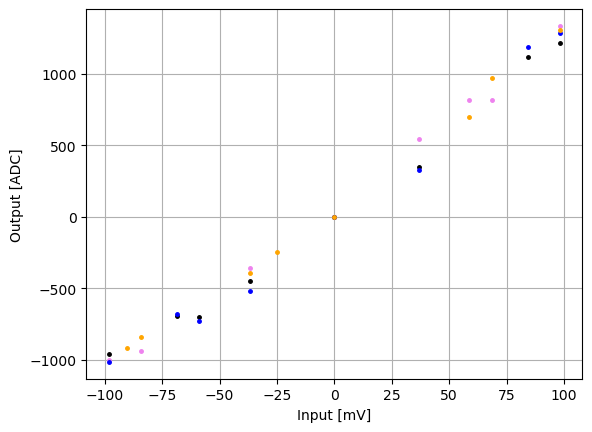

In [417]:
plt.plot(Input_2, event_1, '.', markersize=5, color='violet', label="Input Sine Wave")
plt.plot(Input, event_3, '.', markersize=5, color='black', label="Input Sine Wave")
plt.plot(Input, event_2, '.', markersize=5, color='blue', label="Input Sine Wave")
plt.plot(Input_1, event_0, '.', markersize=5, color='orange', label="Input Sine Wave")
plt.grid()
plt.xlabel("Input [mV]")
plt.ylabel("Output [ADC]")


Input signal: [-90.48 -84.43 -36.81 -24.87   0.    58.78  68.45  98.23]
Input signal: [-98.23 -84.43 -36.81   0.    36.81  58.78  68.45  98.23]
Input signal: [-98.23 -68.45 -58.78 -36.81  -0.    36.81  84.43  98.23]
Input signal: [-98.23 -68.45 -58.78 -36.81  -0.    36.81  84.43  98.23]
Input signal: [-98.23 -84.43 -68.45 -36.81   0.    36.81  84.43  98.23]
Input signal: [-98.23 -68.45 -58.78 -36.81   0.    36.81  84.43  98.23]


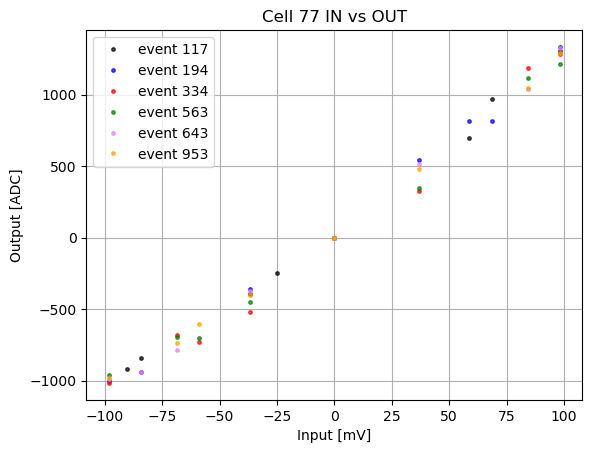

In [418]:
def create_INvsOUT(event_indices, cell_data, cell_number):

    def sinewave(x, A, f, phi, c):
        return A * np.sin(2 * np.pi * f * x + phi) + c
    
    x = np.linspace(0,102.3,1024)
    offset_events = np.zeros(8)
    sine_func = np.zeros(1024)
    color = ['black', 'blue', 'red',  'green', 'violet', 'orange']
    in_values = np.zeros((len(event_indices), 8))
    out_values = np.zeros((len(event_indices), 8))
    for i in range(len(event_indices)):
        input_signal = []
        offset_events = cell_data[cell_number][event_indices[i]*8:event_indices[i]*8+8]
        offset = np.argmin(np.abs(offset_events))
        phase  =  -2  * np.pi * 0.100 * offset * 12.8
        if offset < 7 and offset_events[offset + 1] > 0:
            amplitude = 100
        elif offset > 0 and offset_events[offset - 1] < 0:
            amplitude = 100
        else:
            amplitude = -100
        sine_func = sinewave(x, amplitude, 0.100, phase, 0)
        for j in range(8):
            input_signal.append(sine_func[j*128])
        print("Input signal:", np.sort(input_signal))
        plt.plot(input_signal, offset_events, '.', markersize=5, color=color[i], label=f"event {event_indices[i]}", alpha=0.7)
        in_values[i] = input_signal
        out_values[i] = offset_events
        
    plt.grid()
    plt.legend(loc='upper left')
    plt.xlabel("Input [mV]")
    plt.ylabel("Output [ADC]");
    plt.title(f"Cell {cell_number} IN vs OUT")

    return in_values, out_values

in_values, out_values = create_INvsOUT(event_indices, cell_data, cell_number)


In [419]:
np.set_printoptions(precision=2, suppress=True)
print(in_values)
print(out_values)

[[  0.    98.23 -36.81 -84.43  68.45  58.78 -90.48 -24.87]
 [ 58.78  68.45 -84.43 -36.81  98.23   0.   -98.23  36.81]
 [-58.78 -68.45  84.43  36.81 -98.23  -0.    98.23 -36.81]
 [-58.78 -68.45  84.43  36.81 -98.23  -0.    98.23 -36.81]
 [-84.43 -36.81  98.23   0.   -98.23  36.81  84.43 -68.45]
 [-36.81  98.23   0.   -98.23  36.81  84.43 -68.45 -58.78]]
[[    0.15  1305.65  -395.45  -838.45   971.05   695.35  -920.85  -244.55]
 [  815.45   813.25  -936.45  -359.45  1334.05     0.35 -1003.05   543.15]
 [ -732.15  -679.75  1187.25   329.45 -1015.55     0.25  1283.95  -516.55]
 [ -702.55  -694.25  1114.85   349.85  -957.85     0.65  1214.55  -446.45]
 [ -937.15  -373.65  1324.35     0.45  -987.75   516.55  1040.55  -784.95]
 [ -402.45  1293.35     0.65  -983.55   480.45  1049.75  -739.15  -603.15]]


dict_keys([0.0, 98.23, -36.81, -84.43, 68.45, 58.78, -90.48, -24.87, -98.23, 36.81, -58.78, -68.45, 84.43])
[57.700000000000045, 0.0, 98.70000000000005, 105.20000000000005, 129.0, 157.0999999999999, 0.0, 0.5, 213.70000000000005, 120.10000000000014, 157.79999999999995, 146.70000000000005, 119.5]


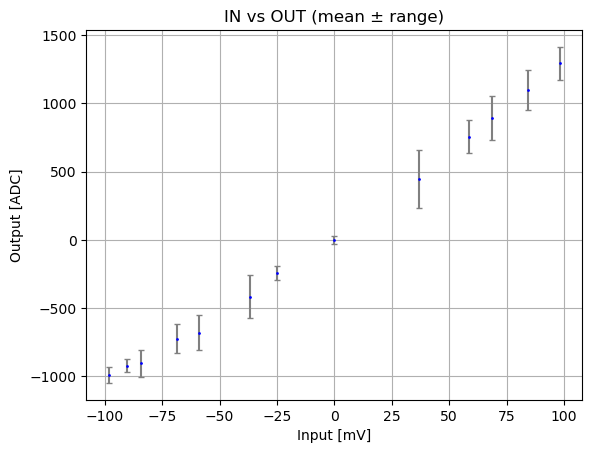

In [455]:
from collections import defaultdict

# Assuming in_values and out_values are already defined from the function
in_flat = in_values.flatten()
out_flat = out_values.flatten()

# Group output values by unique input
grouped_outputs = defaultdict(list)
for x, y in zip(in_flat, out_flat):
    grouped_outputs[round(x, 2)].append(y)  # rounding avoids floating point precision issues

# Prepare lists for plotting
unique_inputs = []
mean_outputs = []
error_bars = []
print(grouped_outputs.keys())
for i in sorted(grouped_outputs.keys()):
    y_vals = grouped_outputs[i]
    unique_inputs.append(i)
    mean_outputs.append(np.mean(y_vals))
    error_bars.append(np.max(y_vals) - np.min(y_vals))  # range as error bar
    
# Plot with error bars
print(error_bars)
error_bars = np.maximum(error_bars, 50)
if 0.0 in unique_inputs:
    idx = unique_inputs.index(0.0)
    error_bars[idx] = 30  # ±10

plt.errorbar(unique_inputs, mean_outputs, yerr=error_bars, fmt='o', markersize=1, capsize=2, ecolor='gray', color='blue')
plt.grid()
plt.xlabel("Input [mV]")
plt.ylabel("Output [ADC]")
plt.title("IN vs OUT (mean ± range)")
plt.show()

Fitted parameters: A=13814.210, B=0.002, C=-0.923, D=10051.718


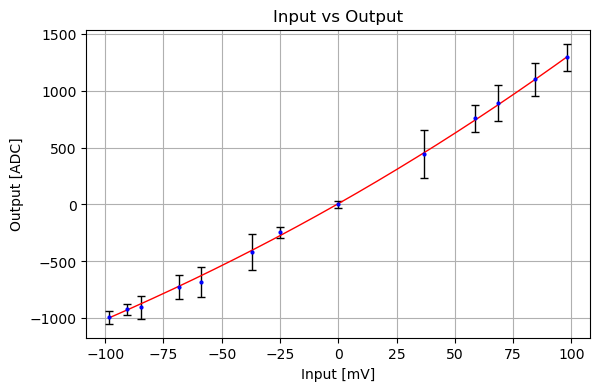

Chi-Squared: 0.715
Reduced Chi-Squared: 0.079


In [458]:
def tanh_fit(x, A, B, C, D):
    return A * np.tanh(B * x + C) + D

# Initial guesses for A, B, C, D (adjust as needed)
initial_guess = [2617, 0.006, -0.439, 1081.681]

# Perform the curve fitting
params, covariance = curve_fit(tanh_fit, unique_inputs, mean_outputs, p0=initial_guess, sigma=error_bars, absolute_sigma=True)

# Extract the fitted parameters
A_fit, B_fit, C_fit, D_fit = params
print(f"Fitted parameters: A={A_fit:.3f}, B={B_fit:.3f}, C={C_fit:.3f}, D={D_fit:.3f}")

# Generate fitted values
x_fit = np.linspace(min(unique_inputs), max(unique_inputs), 1000)
y_fit = tanh_fit(x_fit, *params)

# Plot data with error bars
fig, ax = plt.subplots(figsize=(6.5, 4))
ax.errorbar(unique_inputs, mean_outputs, yerr=error_bars, fmt='o', markersize=2, color='blue', ecolor='black', elinewidth=1, capsize=3, label='Data')

# Plot the tanh fit
ax.plot(x_fit, y_fit, color='red', linewidth=1, label='Tanh Fit')

# Labels and legend
plt.xlabel('Input [mV]')
plt.ylabel('Output [ADC]')
plt.title('Input vs Output')
# ax.legend()
ax.grid()
plt.show()

# Chi squared
unique_inputs = np.array(unique_inputs, dtype=np.float64)
mean_outputs = np.array(mean_outputs, dtype=np.float64)
error_bars = np.array(error_bars, dtype=np.float64)
chi2 = np.sum(((mean_outputs - tanh_fit(unique_inputs, *params)) / error_bars)**2)
dof = len(unique_inputs) - len(params)  
reduced_chi2 = chi2 / dof

print(f"Chi-Squared: {chi2:.3f}")
print(f"Reduced Chi-Squared: {reduced_chi2:.3f}")